# Visualisation Features

In [21]:
import os
os.chdir('D:\open_source\pyshbundle')

import pyshbundle
from tqdm import trange
from datetime import datetime

from pyshbundle.new_io import read_jpl, read_csr, read_tn13, read_tn14, extract_C10_11_replcmnt_coeff, cklm2sc_new
from pyshbundle.new_io import extract_C20_replcmnt_coeff, extract_C30_replcmnt_coeff, replace_zonal_coeff, find_date_in_replacemnt_file
from pyshbundle.new_io import read_itsg

import numpy as np
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

In [83]:
import pyshbundle.reader_replacer_jpl
import pyshbundle.reader_replacer_csr
import pyshbundle.reader_replacer_itsg

from pyshbundle import gshs, plm, sc2cs
from pyshbundle.clm2sc import clm2sc_new
from pyshbundle.clm2cs import clm2cs_new

## Load Data

In [4]:
tn14_path_itsg = 'D:\\open_source\\pyshbundle\pyshbundle\\data\\ITSG_TN_files\\TN-14_C30_C20_SLR_GSFC.txt'
tn_13_path_itsg = 'D:\\open_source\\pyshbundle\\pyshbundle\\data\\ITSG_TN_files\\TN-13_GEOC_CSR_RL06.1.txt'
itsg_folder = 'D:\\open_source\\pyshbundle\\sample_input_data\\ITSG_input'
itsg_file = 'D:\\open_source\\pyshbundle\\sample_input_data\\ITSG_input\\ITSG-Grace2018_n96_2011-05.gfc'

In [5]:
data_itsg_mat= np.ndarray((4753, 6))
header = read_itsg(itsg_file)[0]
data_itsg_mat = read_itsg(itsg_file)[1]
dates_itsg = read_itsg(itsg_file)[2]

In [12]:
scmat_itsg, devscmat_itsg = clm2sc_new(data_itsg_mat, lmax=96, sigma_flag=True)

In [7]:
# Read replacemnt file
data_tn13_itsg = read_tn13(tn_13_path_itsg)
data_tn14_itsg = read_tn14(tn14_path_itsg)

In [13]:
replaced_data_mat = replace_zonal_coeff(data_itsg_mat, 'itsg', 96, data_tn13_itsg, data_tn14_itsg, dates_itsg, epoch_end=None)

Data Date - 2011-05-01, replacemnt date(tn-13) = 2011-05-01
Data Date - 2011-05-01, replacemnt date(tn-13) = 2011-05-01
[1.00000000e+00 0.00000000e+00 1.92070086e-12 0.00000000e+00
 4.45850000e-11 0.00000000e+00] [ 1.00000000e+00  1.00000000e+00  1.19237304e-10 -1.66149501e-10
  4.52960000e-11  5.07240000e-11]
Data Date - 2011-05-01, replacemnt date (tn-14)_ = 2011-05-01
Data Date - 2011-05-01, replacemnt date (tn-14)_ = 2011-05-01


In [15]:
rep_sc, rep_dev = clm2sc_new(replaced_data_mat, lmax=96, sigma_flag=True)

## Computation

# Visualise data

In [120]:
def sc_triplot(scmat: np.ndarray, lmax: int, title: str, vmin, vmax):
    """
    """
    fig, ax = plt.subplots(1, 1, figsize=(25, 10))
    im = ax.imshow(np.ma.log10(abs(scmat)), extent=[-lmax, lmax, lmax, 0], cmap='Spectral_r',vmin=vmin, vmax=vmax)
    ax.grid()
    # plt.colorbar()
    x_vec = np.arange(-lmax, lmax+1, 6)
    y_vec = np.arange(lmax, -2, -6)

    x_st = 0*y_vec

    # vertical line
    ax.plot(x_st, y_vec, "black") 

    plt.xticks(x_vec,)
    plt.yticks(y_vec)
    plt.title(title)
    fig.colorbar(im,)    
    return ax

def cs_sqplot(csmat: np.ndarray, lmax: int, title: str, vmin, vmax):
    """
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    im = ax.imshow(np.ma.log10(abs(csmat)), extent=[0, lmax, lmax, 0], cmap='Spectral_r',vmin=vmin, vmax=vmax)
    ax.grid()
    ax.set_aspect('equal')

    # plt.colorbar()
    x_vec = np.arange(0, lmax+1, 6)
    y_vec = np.arange(lmax, -2, -6)

    # diagonal line
    ax.plot(x_vec, np.flip(y_vec), "black") 

    # formating
    plt.xticks(x_vec,)
    plt.yticks(y_vec)
    plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.45)
    
    # Plot horizontal colorbar
    plt.colorbar(im, orientation="horizontal", cax=cax)
    
    return ax



## SC_Tri_Plot

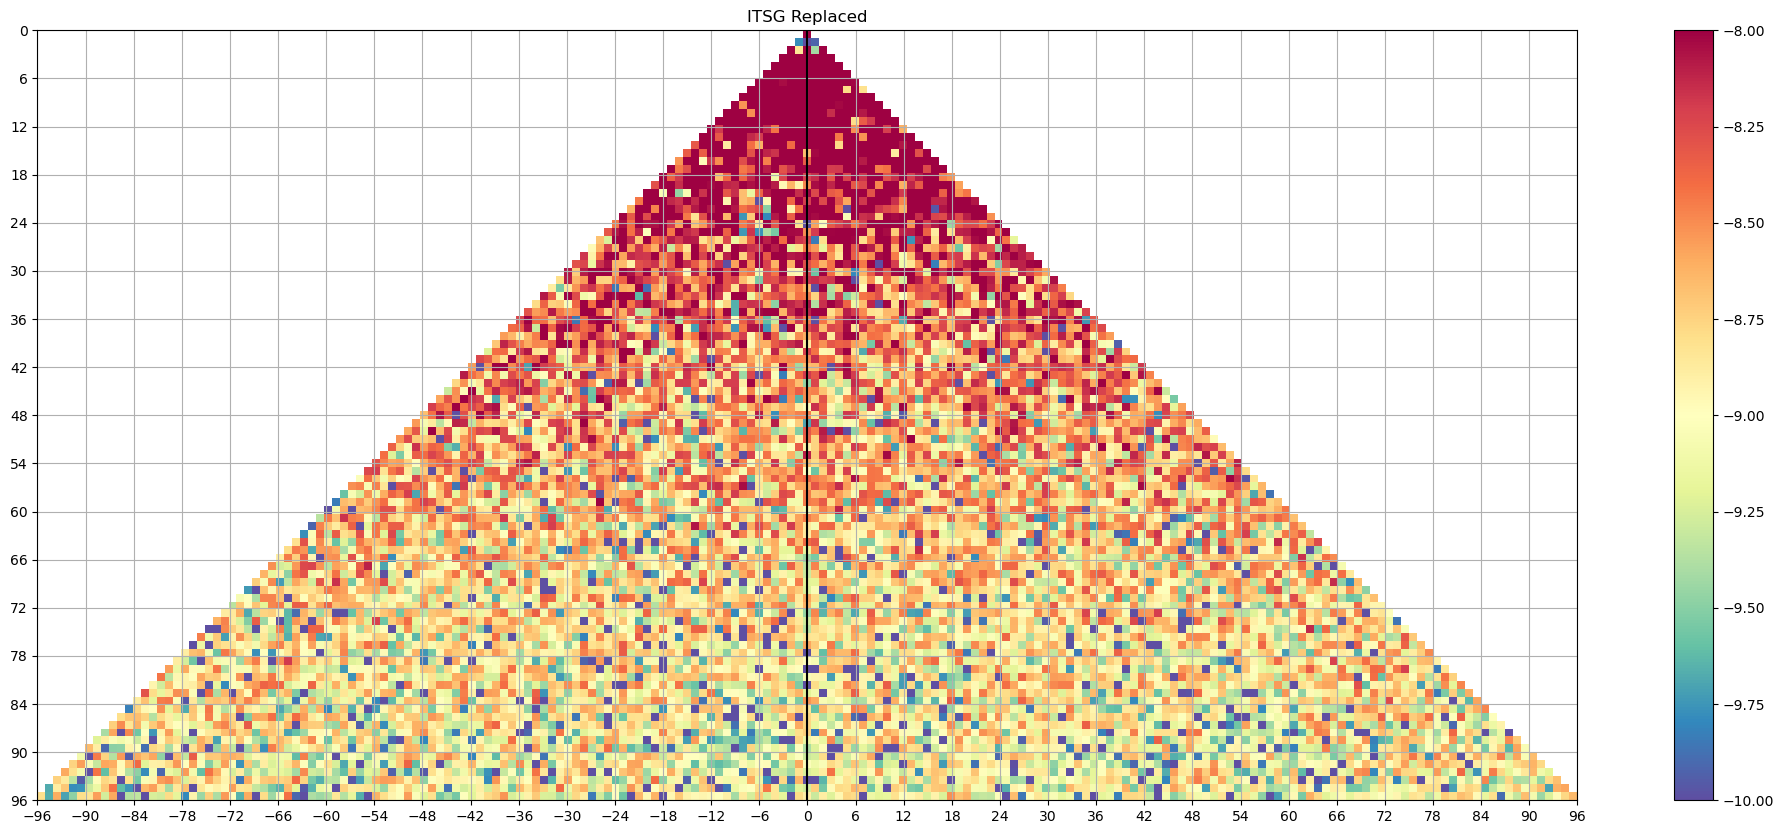

In [121]:
handle = sc_triplot(scmat=rep_sc, lmax=96, title="ITSG Replaced", vmin=-10, vmax=-8)

## CS_Sq_Plot

In [102]:
rep_cs = sc2cs.sc2cs(rep_sc)
from mpl_toolkits.axes_grid1 import make_axes_locatable

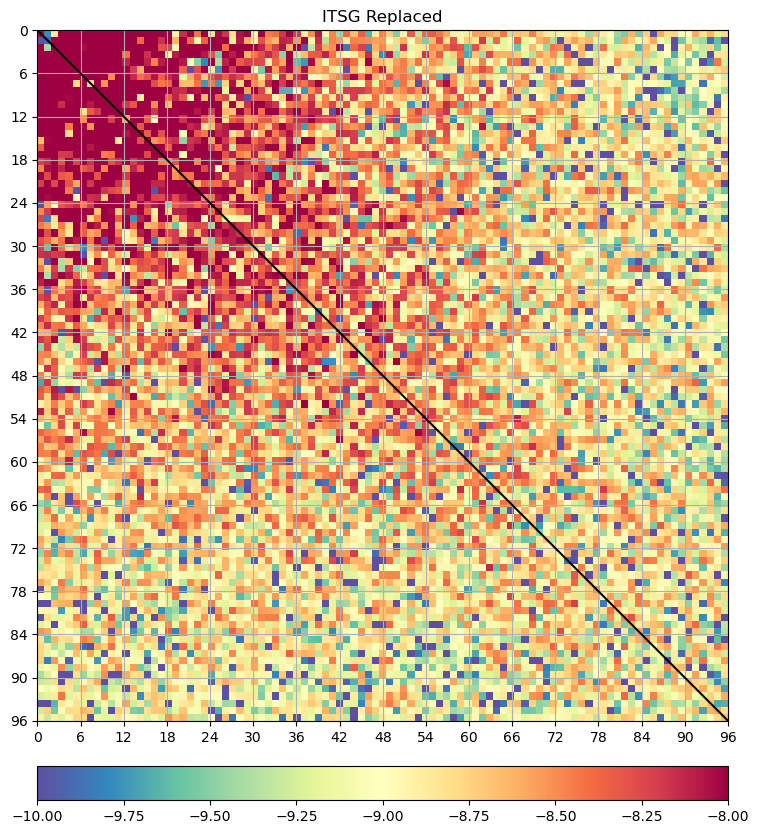

In [119]:
handle = cs_sqplot(csmat=rep_cs, lmax=96, title="ITSG Replaced", vmin=-10, vmax=-8)

## Surface Spherical Harmonics

In [28]:
def surface_spherical_hormonics(l: int, m: int):
    """_summary_

    Args:
        l (int): Degree
        m (int): Order

    Returns:
        _type_: _description_
    """

    # input handling
    assert l >= 0
    assert abs(m) >= 0
    assert m <= l

    m = abs(m)
    # main code
    thetaRAD  = np.linspace(0,np.pi,37)
    lambdaRAD = np.linspace(0,2*np.pi,73)

    cosml = np.cos(m*lambdaRAD)
    sinml = np.sin(m*lambdaRAD)

    arr = np.zeros((1,1))
    arr[0] = l
    
    p = plm.plm(arr, m, thetaRAD, nargin=1, nargout=1)

    ylmc = p * cosml
    ylms = p * sinml

    return (ylmc, ylms)

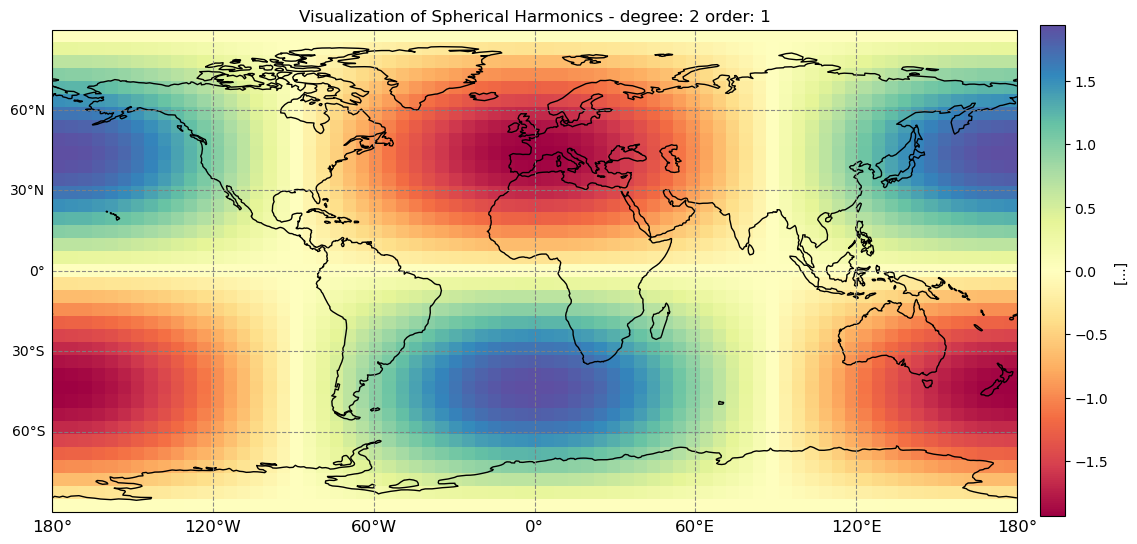

In [38]:
# basic plotting of SH coeff on plane
l = 2
m = 1

ylmc_00, ylms_00 = surface_spherical_hormonics(l=l, m=m)

fig = plt.figure(figsize=(15, 7.5))
ax = plt.axes(projection = ccrs.PlateCarree())

lons = np.linspace(-180, 180, 73)
lats = np.linspace(-90, 90, 37)

x, y = np.meshgrid(lons, lats)

if m >=0 :

    img_extent = (-180, 180, -90, 90)

    # plot the data
    im = ax.imshow(ylmc_00[:, 0, :], origin='upper', extent=img_extent, transform=ccrs.PlateCarree(), cmap="Spectral")
else:
    #plt.contourf(x, y, ylms_00[:, 0, :], cmap='RdYlBu_r')
    im = ax.imshow(ylms_00[:, 0, :], origin='upper', extent=img_extent, transform=ccrs.PlateCarree(), cmap="Spectral")



# setting gridlines
gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, color='gray', alpha=0.9, linestyle='--')
# remove top x label
gl.top_labels = False
# change x label styles - font size ad colour
gl.xlabel_style = {'size':12,}
# left and right labels
gl.left_labels = True
gl.right_labels = False
# coastlines
ax.coastlines()

plt.colorbar(im, orientation='vertical', shrink=0.85, pad=0.02,label=f"[...]")

plt.title(f"Visualization of Spherical Harmonics - degree: {l} order: {m}")
plt.show()


## Gravity Field

In [ ]:
def mapfield():
    pass

## Time Lapse of Temporal Gravity Variations

In [ ]:
def stack_maps():
    pass
